# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 1.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [2]:
!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

In [9]:
def box_plot(df, col):
    """
    функция строит график категориальных переменных
    """
    plt.figure(figsize=(10, 5))
    g1 = sns.boxplot(y='price', x=col, 
                      data=df, color='coral')
    g1.set_title(col + ' ' +' price', fontsize=20)

    g1.set_ylabel('price', fontsize=15)
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()

In [10]:
def df_description(df):
    """
    фнкция, возвращает словарь с описанием датафрейма
    """
    df_dict = {}
    for column in df.columns:
        temp_dict = {}
        temp_dict['type'] = df[column].dtype.kind
        temp_dict['# values'] = df[column].count()
        temp_dict['% na'] = df[column].isna().sum()/df[column].count()
        temp_dict['# unique'] = df[column].nunique()
        temp_dict['example'] = df[column].dropna().unique()[0]
        df_dict[column] = temp_dict
    return df_dict

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [11]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [13]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [14]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [15]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
pd.DataFrame.from_dict(df_description(data), orient='index')

,type,# values,% na,# unique,example
bodyType,O,8353,0.000000,17,универсал 5 дв.
brand,O,8353,0.000000,3,MERCEDES
color,O,8353,0.000000,16,чёрный
description,O,8353,0.000000,7654,Всем привет!\n\nПродам эксклюзивный проект 124...
engineDisplacement,O,8353,0.000000,48,3.0 LTR
enginePower,O,8353,0.000000,154,220 N12
fuelType,O,8353,0.000000,4,бензин
mileage,i,8353,0.000000,3507,350000
modelDate,i,8353,0.000000,43,1984
model_info,O,8353,0.000000,122,W124


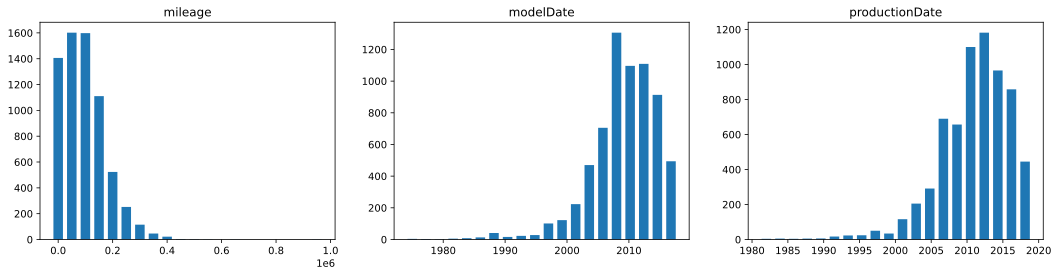

In [18]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

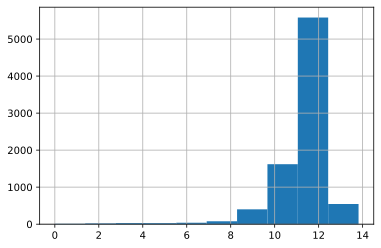

In [19]:
data['log_mileage'] = np.log(data['mileage'])
data['log_mileage'].hist()

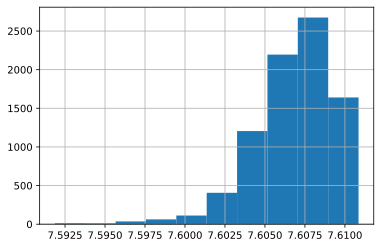

In [20]:
data['log_productionDate'] = np.log(data['productionDate'])
data['log_productionDate'].hist()

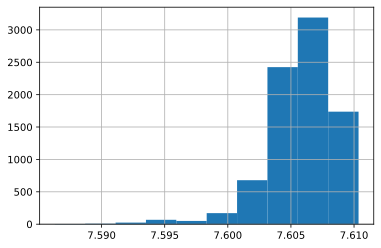

In [21]:
data['log_modelDate'] = np.log(data['modelDate'])
data['log_modelDate'].hist()

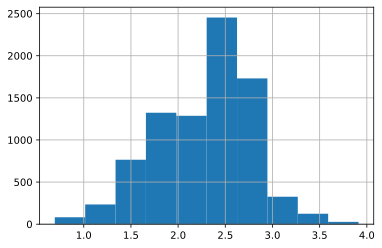

In [22]:
data['modelDate'] = 2021 - data['modelDate']
data['log_modelDate'] = np.log(data['modelDate'])
data['log_modelDate'].hist()

# PreProc Tabular Data

In [23]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [24]:
data.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Владельцы,Владение,ПТС,Привод,Руль,sample,price,log_mileage,log_productionDate,log_modelDate
7399,внедорожник 5 дв.,BMW,коричневый,"Авто в одних руках,все обслуживание по реглам...",2.0 LTR,245 N12,бензин,107000,7,X3,...,1 владелец,4 года и 9 месяцев,Оригинал,полный,Левый,1,1590000.0,11.580584,7.608374,1.945910
4273,внедорожник 5 дв.,BMW,чёрный,"Год выпуска 2016, приобрел новую без пробега в...",2.0 LTR,245 N12,гибрид,45000,8,X5,...,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый,1,3100000.0,10.714418,7.608871,2.079442
3362,седан,MERCEDES,чёрный,В идеальном состоянии. Обслуживание в Панавто ...,5.5 LTR,585 N12,бензин,55000,8,S_KLASSE_AMG,...,3 или более,NaN,Оригинал,полный,Левый,1,3750000.0,10.915088,7.608374,2.079442
2794,седан,AUDI,белый,"Эксклюзивный Audi A6, модельный ряд 2012 года....",3.0 LTR,245 N12,дизель,125000,10,A6,...,3 или более,NaN,Оригинал,полный,Левый,1,1990000.0,11.736069,7.606387,2.302585
5378,седан,BMW,чёрный,CОСТОЯНИЕ КАК У НОВОГО АВТОМОБИЛЯ !!! ОЧЕНЬ НА...,2.0 LTR,218 N12,дизель,149000,8,5ER,...,3 или более,NaN,Оригинал,полный,Левый,1,1285000.0,11.911702,7.608374,2.079442


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [26]:
data['bodyType'].unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

In [27]:
data['brand'].unique()

array(['MERCEDES', 'BMW', 'AUDI'], dtype=object)

In [28]:
data['color'].unique()

array(['чёрный', 'белый', 'пурпурный', 'синий', 'коричневый', 'серый',
       'зелёный', 'серебристый', 'красный', 'оранжевый', 'голубой',
       'фиолетовый', 'бежевый', 'жёлтый', 'золотистый', 'розовый'],
      dtype=object)

In [29]:
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
321 N12      1
591 N12      1
114 N12      1
132 N12      1
133 N12      1
Name: enginePower, Length: 154, dtype: int64

Переведем это в числовое поле

In [30]:
data['enginePower'] = data['enginePower'].str.split().apply(lambda s: s[0])
data['enginePower'] = data['enginePower'].apply(lambda s: float(s))

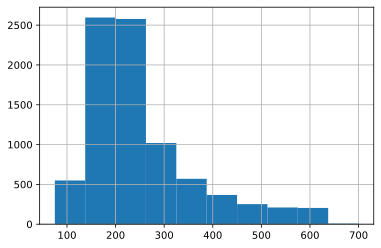

In [31]:
data['enginePower'].hist()

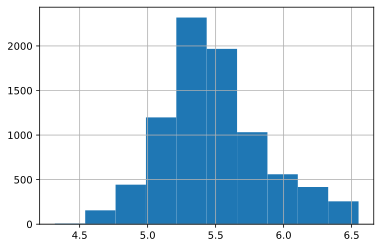

In [32]:
data['log_enginePower'] = np.log(data['enginePower'])
data['log_enginePower'].hist()

In [33]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
2.3 LTR            14
3.7 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
5.8 LTR             5
6.6 LTR             5
4.6 LTR             5
1.9 LTR             5
3.4 LTR             4
4.3 LTR             4
5.6 LTR             3
6.3 LTR   

In [34]:
# заменим средним двух самых частых литражей
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.5 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
data['engineDisplacement'] = pd.to_numeric(data['engineDisplacement'], errors='coerce')
data['engineDisplacement'].value_counts()

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
2.5     254
3.5     250
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
3.1      44
2.4      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
3.6      23
4.1      23
1.7      15
3.7      14
2.3      14
5.2      13
5.9      11
2.6       9
0.7       6
1.9       5
5.8       5
6.6       5
4.6       5
4.3       4
3.4       4
6.3       3
3.8       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64

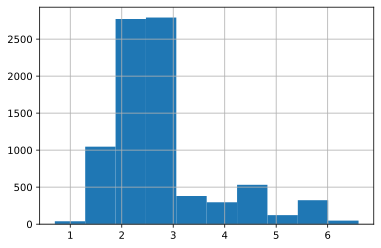

In [35]:
data['engineDisplacement'].hist()

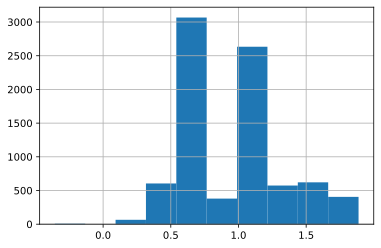

In [36]:
data['log_engineDisplacement'] = np.log(data['engineDisplacement'])
data['log_engineDisplacement'].hist()

In [37]:
# заменим средним двух самых частых литражей
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.5 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
data['engineDisplacement'] = pd.to_numeric(data['engineDisplacement'], errors='coerce')
data['engineDisplacement'].value_counts()

2.0    2430
3.0    2349
1.8     411
1.6     410
4.4     329
5.5     268
2.5     254
3.5     250
2.1     221
4.0     153
4.7     137
2.8     106
1.4     106
4.2     103
5.0      74
1.5      73
3.2      60
2.2      58
4.8      57
2.9      50
3.1      44
2.4      44
6.2      40
6.0      37
5.4      33
1.2      33
1.3      32
2.7      24
3.6      23
4.1      23
1.7      15
3.7      14
2.3      14
5.2      13
5.9      11
2.6       9
0.7       6
1.9       5
5.8       5
6.6       5
4.6       5
4.3       4
3.4       4
6.3       3
3.8       3
5.6       3
4.9       2
Name: engineDisplacement, dtype: int64

In [38]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [39]:
data.loc[data['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'
data['Владельцы'].value_counts()

3 или более    3312
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

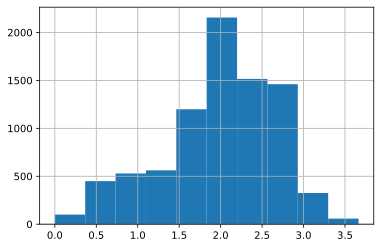

In [40]:
data['productionDate'] = 2021 - data['productionDate']
data['log_productionDate'] = np.log(data['productionDate'])
data['log_productionDate'].hist()

In [41]:
data['Владение'].value_counts(dropna=False)

NaN                    5418
1 год и 8 месяцев        67
1 год и 2 месяца         67
1 год                    55
2 года и 2 месяца        52
                       ... 
17 лет и 4 месяца         1
17 лет                    1
18 лет и 7 месяцев        1
16 лет и 1 месяц          1
16 лет и 10 месяцев       1
Name: Владение, Length: 181, dtype: int64

In [42]:
data['mileage_to_age'] = data['mileage']/data['productionDate']

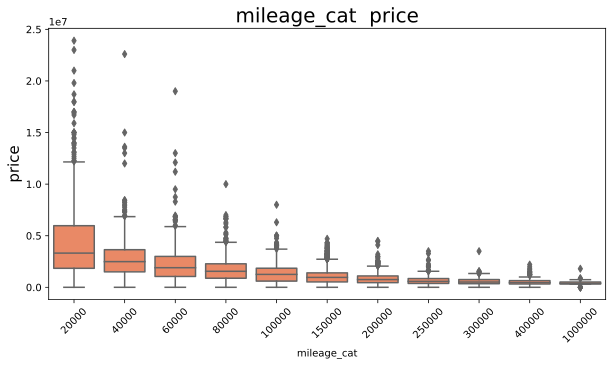

In [43]:
bins = [-1, 20000, 40000, 60000, 80000, 100000, 150000, 200000, 250000, 300000, 400000, 1000001]
numbers = ['20000', '40000','60000','80000','100000', '150000', '200000','250000','300000','400000','1000000']
data['mileage_cat']=pd.cut(data['mileage'],bins,labels=numbers)
box_plot(data,'mileage_cat')

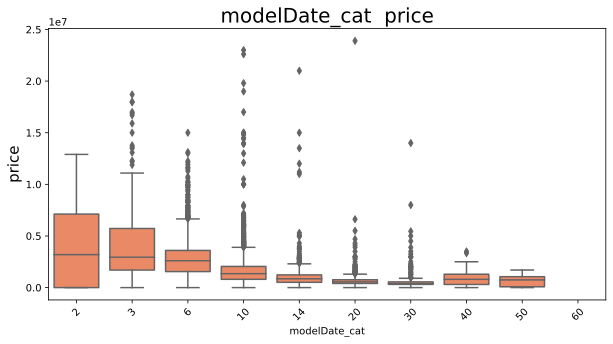

In [44]:
bins = [-1, 2, 3, 6, 10, 14, 20, 30, 40, 50, 60]
numbers = ['2','3','6','10','14','20','30','40','50','60']

data['modelDate_cat']=pd.cut(data['modelDate'],bins,labels=numbers)
box_plot(data,'modelDate_cat')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   bodyType                8353 non-null   object  
 1   brand                   8353 non-null   object  
 2   color                   8353 non-null   object  
 3   description             8353 non-null   object  
 4   engineDisplacement      8353 non-null   float64 
 5   enginePower             8353 non-null   float64 
 6   fuelType                8353 non-null   object  
 7   mileage                 8353 non-null   int64   
 8   modelDate               8353 non-null   int64   
 9   model_info              8353 non-null   object  
 10  name                    8353 non-null   object  
 11  numberOfDoors           8353 non-null   int64   
 12  productionDate          8353 non-null   int64   
 13  sell_id                 8353 non-null   int64   
 14  vehicleConfiguration    

In [46]:
num_cols = ['engineDisplacement','enginePower','mileage','modelDate','productionDate','numberOfDoors',
            'log_enginePower','log_mileage','log_productionDate','log_modelDate','log_engineDisplacement','price']

In [47]:
correlation = data[num_cols].corr()
correlation

,engineDisplacement,enginePower,mileage,modelDate,productionDate,numberOfDoors,log_enginePower,log_mileage,log_productionDate,log_modelDate,log_engineDisplacement,price
engineDisplacement,1.000000,0.860278,0.048648,0.194770,0.209383,-0.011074,0.859380,0.011734,0.186380,0.179781,0.978835,0.241325
enginePower,0.860278,1.000000,-0.184616,-0.101825,-0.085100,-0.031772,0.971142,-0.170577,-0.082074,-0.104197,0.842399,0.404552
mileage,0.048648,-0.184616,1.000000,0.672522,0.702970,0.038435,-0.157443,0.714255,0.718316,0.698114,0.079521,-0.436743
modelDate,0.194770,-0.101825,0.672522,1.000000,0.964919,-0.112091,-0.093699,0.515007,0.868919,0.933065,0.202688,-0.397267
productionDate,0.209383,-0.085100,0.702970,0.964919,1.000000,-0.124278,-0.073721,0.551173,0.916965,0.906883,0.218433,-0.417464
numberOfDoors,-0.011074,-0.031772,0.038435,-0.112091,-0.124278,1.000000,-0.021130,0.015292,-0.098621,-0.090086,0.007978,0.018068
log_enginePower,0.859380,0.971142,-0.157443,-0.093699,-0.073721,-0.021130,1.000000,-0.145870,-0.069296,-0.092022,0.872942,0.372622
log_mileage,0.011734,-0.170577,0.714255,0.515007,0.551173,0.015292,-0.145870,1.000000,0.721958,0.639153,0.026966,-0.557229
log_productionDate,0.186380,-0.082074,0.718316,0.868919,0.916965,-0.098621,-0.069296,0.721958,1.000000,0.937922,0.193343,-0.513643
log_modelDate,0.179781,-0.104197,0.698114,0.933065,0.906883,-0.090086,-0.092022,0.639153,0.937922,1.000000,0.188888,-0.480133


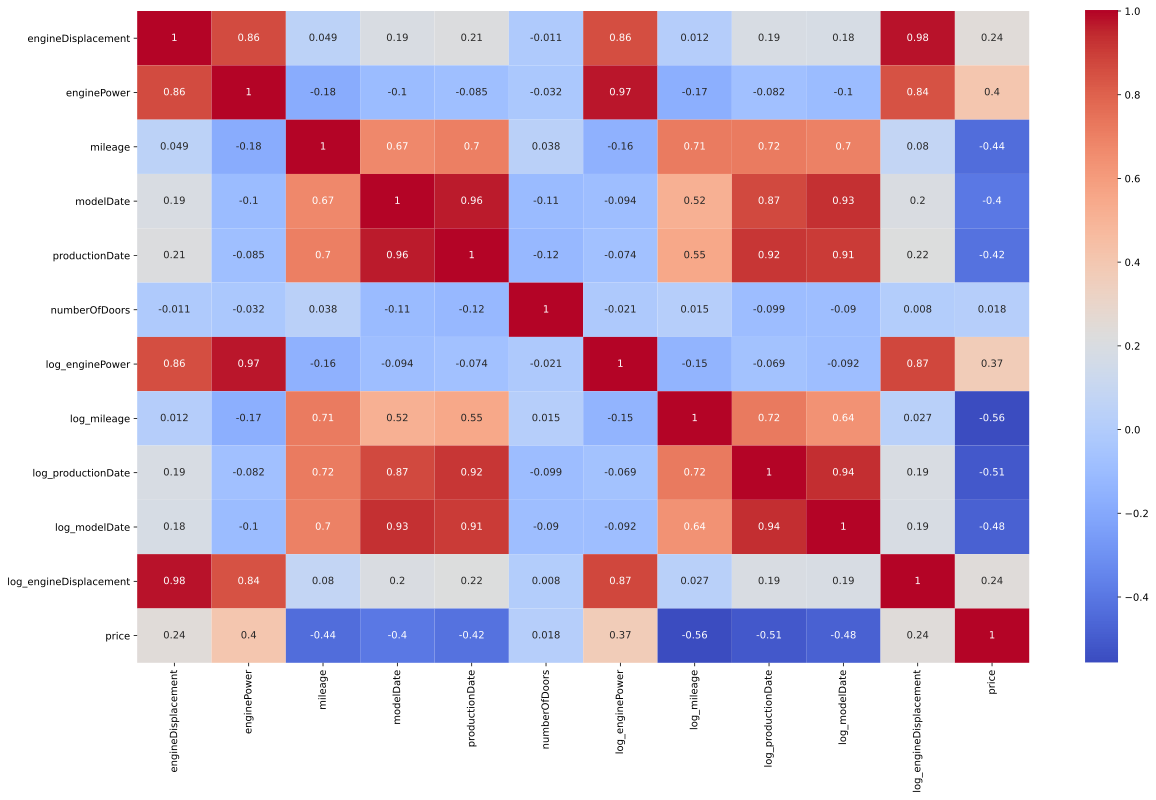

In [48]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [49]:
data.corr().abs().sort_values(by='price', ascending=False)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,sample,price,log_mileage,log_productionDate,log_modelDate,log_enginePower,log_engineDisplacement,mileage_to_age
price,0.241325,0.404552,0.436743,0.397267,0.018068,0.417464,0.019779,0.405771,1.000000,0.557229,0.513643,0.480133,0.372622,0.237285,0.269509
log_mileage,0.011734,0.170577,0.714255,0.515007,0.015292,0.551173,0.014410,0.001610,0.557229,1.000000,0.721958,0.639153,0.145870,0.026966,0.596621
log_productionDate,0.186380,0.082074,0.718316,0.868919,0.098621,0.916965,0.047650,0.002965,0.513643,0.721958,1.000000,0.937922,0.069296,0.193343,0.143167
log_modelDate,0.179781,0.104197,0.698114,0.933065,0.090086,0.906883,0.043933,0.006772,0.480133,0.639153,0.937922,1.000000,0.092022,0.188888,0.113512
mileage,0.048648,0.184616,1.000000,0.672522,0.038435,0.702970,0.010300,0.003900,0.436743,0.714255,0.718316,0.698114,0.157443,0.079521,0.601572
productionDate,0.209383,0.085100,0.702970,0.964919,0.124278,1.000000,0.042841,0.008146,0.417464,0.551173,0.916965,0.906883,0.073721,0.218433,0.027846
sample,0.009075,0.004199,0.003900,0.011782,0.014501,0.008146,0.000134,1.000000,0.405771,0.001610,0.002965,0.006772,0.002630,0.007235,0.003277
enginePower,0.860278,1.000000,0.184616,0.101825,0.031772,0.085100,0.000859,0.004199,0.404552,0.170577,0.082074,0.104197,0.971142,0.842399,0.209323
modelDate,0.194770,0.101825,0.672522,1.000000,0.112091,0.964919,0.038045,0.011782,0.397267,0.515007,0.868919,0.933065,0.093699,0.202688,0.023480
log_enginePower,0.859380,0.971142,0.157443,0.093699,0.021130,0.073721,0.000902,0.002630,0.372622,0.145870,0.069296,0.092022,1.000000,0.872942,0.177094


In [50]:
categorical_features = [
    'bodyType', 
    'brand', 
    'color',
    'fuelType', 
    'model_info',
    'vehicleTransmission', 
    'Привод',
    'mileage_cat',
    'modelDate_cat',
        'Владельцы',
    'ПТС'
]

numerical_features = [
    'engineDisplacement',
    'enginePower', 
    'modelDate', 
    'numberOfDoors',
    'mileage_to_age'
]

In [51]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'name', 'sell_id', 'vehicleConfiguration', 'Владение', 'Руль','mileage',
                   'productionDate','log_enginePower','log_engineDisplacement'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [52]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,modelDate,numberOfDoors,sample,price,log_mileage,log_productionDate,log_modelDate,mileage_to_age,...,modelDate_cat_4,modelDate_cat_5,modelDate_cat_6,modelDate_cat_7,modelDate_cat_8,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1
3640,0.220339,0.2000,0.229167,1.000000,1,630000.0,12.314927,2.564949,2.564949,0.222997,...,1,0,0,0,0,1,0,0,0,1
6421,0.220339,0.1200,0.208333,1.000000,1,680000.0,11.967784,2.197225,2.484907,0.227634,...,1,0,0,0,0,0,1,0,0,1
7645,0.186441,0.1360,0.250000,0.666667,1,599000.0,11.461632,2.484907,2.639057,0.102913,...,1,0,0,0,0,0,1,0,0,1
7222,0.220339,0.2720,0.083333,1.000000,1,2150000.0,10.463103,1.609438,1.791759,0.090996,...,0,0,0,0,0,0,1,0,0,1
4604,0.389831,0.2928,0.208333,0.666667,1,1290000.0,11.775290,2.197225,2.484907,0.187774,...,1,0,0,0,0,0,1,0,0,1
5140,0.101695,0.1200,0.020833,1.000000,1,1898000.0,9.306378,0.693147,1.098612,0.071548,...,0,0,0,0,0,1,0,0,0,1
728,0.186441,0.1360,0.250000,0.666667,0,0.0,11.976659,2.302585,2.639057,0.206697,...,1,0,0,0,0,0,0,1,0,1
7029,0.305085,0.2288,0.354167,0.666667,1,675000.0,11.472103,2.708050,2.944439,0.083196,...,0,1,0,0,0,1,0,0,0,1
1997,0.389831,0.3696,0.250000,1.000000,1,970000.0,12.338000,2.484907,2.639057,0.247219,...,1,0,0,0,0,0,0,1,0,1
3433,0.220339,0.2176,0.166667,1.000000,1,890000.0,11.982929,2.197225,2.302585,0.231108,...,0,0,0,0,0,0,0,1,0,1


In [53]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 204 entries, engineDisplacement to ПТС_1
dtypes: float64(9), int64(1), uint8(194)
memory usage: 2.2 MB


## Split data

In [54]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 203 entries, engineDisplacement to ПТС_1
dtypes: float64(9), uint8(194)
memory usage: 447.1 KB


# Model 2: CatBoostRegressor

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [57]:
model = CatBoostRegressor(iterations = 8000,
                          #depth=10,
                          learning_rate = 0.025,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.9843892	test: 1.0084905	best: 1.0084905 (0)	total: 54.1ms	remaining: 7m 12s
100:	learn: 0.2904288	test: 0.2903208	best: 0.2903208 (100)	total: 403ms	remaining: 31.5s
200:	learn: 0.2247041	test: 0.2230056	best: 0.2230056 (200)	total: 695ms	remaining: 26.9s
300:	learn: 0.1928591	test: 0.1943028	best: 0.1943028 (300)	total: 991ms	remaining: 25.3s
400:	learn: 0.1781111	test: 0.1806781	best: 0.1806781 (400)	total: 1.29s	remaining: 24.4s
500:	learn: 0.1712220	test: 0.1747392	best: 0.1747392 (500)	total: 1.59s	remaining: 23.8s
600:	learn: 0.1625412	test: 0.1665072	best: 0.1665072 (600)	total: 1.89s	remaining: 23.2s
700:	learn: 0.1550944	test: 0.1601169	best: 0.1601169 (700)	total: 2.19s	remaining: 22.8s
800:	learn: 0.1494436	test: 0.1554865	best: 0.1554776 (795)	total: 2.49s	remaining: 22.4s
900:	learn: 0.1447976	test: 0.1523585	best: 0.1523526 (899)	total: 2.79s	remaining: 22s
1000:	learn: 0.1405857	test: 0.1499541	best: 0.1499541 (1000)	total: 3.09s	remaining: 21.6s
1100:	learn:

In [58]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.69%


### Submission

In [59]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [60]:
!pip install -U lightautoml

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task



     |████████████████████████████████| 250 kB 1.2 MB/s 
     |████████████████████████████████| 2.2 MB 4.8 MB/s 
     |████████████████████████████████| 804.1 MB 2.2 kB/s 
     |████████████████████████████████| 204 kB 5.5 MB/s 
     |████████████████████████████████| 424 kB 16.7 MB/s 
     |████████████████████████████████| 232 kB 17.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bc2b58e1d46f8fc203100f9a635b3a14863ce0a7bebf8fe930ac62d5087c6a6b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7596 sha256=68ebae706a912f53040668487b99038eed93f3c65362821a3e6f4bd33bed34d9
  Stored in directory: /root/.cache/pip/wheels/e5/99/37/e1839a5ad733e0d6abb7e0419fd913e8926ddf96408239ce01
  Created wheel for log-calls: filename=log_calls

In [61]:
# Задаем параметры

N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 7200 # Time in seconds for automl run

np.random.seed(RANDOM_STATE)



In [62]:
from sklearn.metrics import mean_squared_log_error

# Создаем задание
task = Task('reg', loss = 'rmsle', metric = 'rmsle')

# Создаем роли
roles = {'target': 'price'}

In [63]:
# Сплитанем данные для обучения
tr_data, te_data = train_test_split(train_data, 
                                      test_size=TEST_SIZE,
                                      random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (5345, 203), te_data = (1337, 203)


In [64]:
# # Train AutoML
automl = TabularAutoML(task = task, 
                    timeout = TIMEOUT,
                    cpu_limit = N_THREADS,
                    #reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                     verbose = 1)
oof_pred = automl.fit_predict(tr_data, roles = roles)

# Predict on test
test_pred = automl.predict(te_data)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use

In [65]:
test_pred_full = test_pred.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(te_data['price'].values, test_pred_full))*100:0.2f}%")

TEST mape: 12.42%


In [66]:
sub_predict_automl = automl.predict(X_sub).data[:, 0].copy().round(0)
sample_submission['price'] = sub_predict_automl
sample_submission.to_csv('autoML_submission.csv', index=False)

# Model 4: Tabular NN

Построим обычную сеть:

In [67]:
X_train.head(5)

,engineDisplacement,enginePower,modelDate,numberOfDoors,log_mileage,log_productionDate,log_modelDate,mileage_to_age,bodyType_0,bodyType_1,...,modelDate_cat_4,modelDate_cat_5,modelDate_cat_6,modelDate_cat_7,modelDate_cat_8,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1
7320,0.898305,0.7504,0.229167,0.666667,11.918391,2.302585,2.564949,0.194997,0,0,...,1,0,0,0,0,1,0,0,0,1
8037,0.220339,0.2720,0.062500,1.000000,9.949512,1.098612,1.609438,0.090745,0,1,...,0,0,0,0,0,1,0,0,0,1
4681,0.406780,0.2880,0.312500,0.666667,11.804826,2.708050,2.833213,0.116040,0,0,...,0,1,0,0,0,0,0,1,0,1
6014,0.186441,0.1744,0.270833,0.666667,12.706848,2.639057,2.708050,0.306426,0,0,...,0,1,0,0,0,0,0,1,0,1
3649,0.389831,0.3808,0.166667,0.666667,11.744037,2.079442,2.302585,0.204747,0,0,...,0,0,0,0,0,1,0,0,0,1


## Simple Dense NN

In [68]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               103936    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 235,521
Trainable params: 235,521
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [71]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [72]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

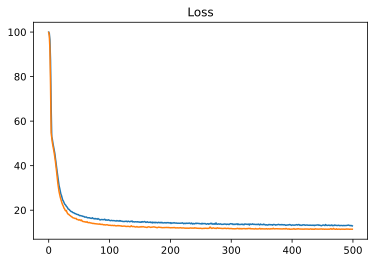

In [73]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [74]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [75]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.45%


In [76]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 5: NLP + Multiple Inputs

In [77]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [78]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [79]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [80]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.33 s, sys: 6.59 ms, total: 1.34 s
Wall time: 1.34 s


In [81]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [82]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.34 s, sys: 1.58 ms, total: 1.34 s
Wall time: 1.34 s


In [83]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [84]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [85]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [86]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [87]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [88]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [89]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [90]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 444ms/step - loss: 99.9481 - MAPE: 99.9481 - val_loss: 99.5492 - val_MAPE: 99.5492
Epoch 2/500
12/12 [==============================] - 5s 384ms/step - loss: 97.3742 - MAPE: 97.3742 - val_loss: 89.8614 - val_MAPE: 89.8614
Epoch 3/500
12/12 [==============================] - 4s 366ms/step - loss: 73.1740 - MAPE: 73.1740 - val_loss: 52.2518 - val_MAPE: 52.2518
Epoch 4/500
12/12 [==============================] - 4s 374ms/step - loss: 54.7621 - MAPE: 54.7621 - val_loss: 50.1697 - val_MAPE: 50.1697
Epoch 5/500
12/12 [==============================] - 4s 367ms/step - loss: 50.3135 - MAPE: 50.3135 - val_loss: 47.7015 - val_MAPE: 47.7015
Epoch 6/500
12/12 [==============================] - 5s 382ms/step - loss: 47.2961 - MAPE: 47.2961 - val_loss: 44.4532 - val_MAPE: 44.4532
Epoch 7/500
12/12 [==============================] - 5s 398ms/step - loss: 43.4202 - MAPE: 43.4202 - val_loss: 40.3242 - val_MAPE: 40.3242
Epoch 8/500
12/12 [========

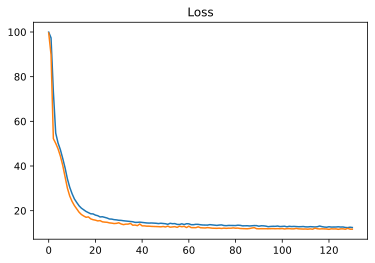

In [91]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [92]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [93]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.72%


In [94]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

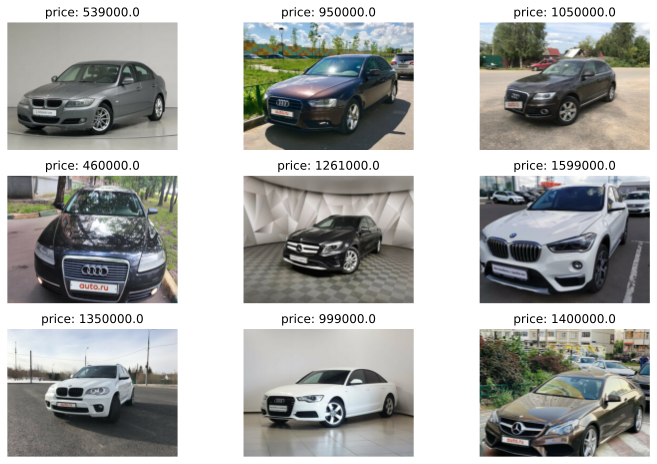

In [95]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [96]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

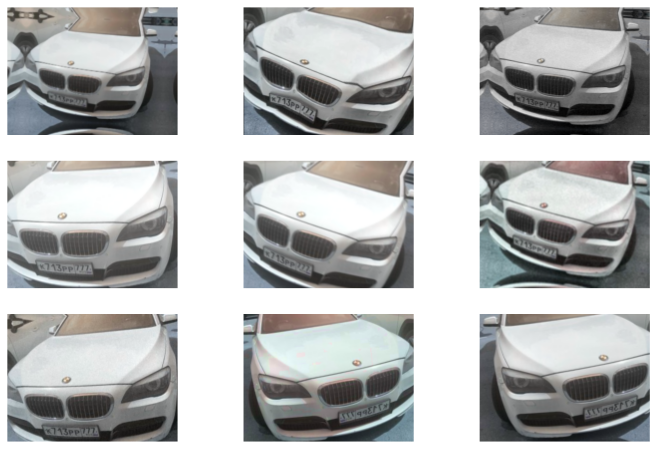

In [97]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [98]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [99]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [100]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [101]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [102]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [103]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [104]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [105]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [106]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [107]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 149s 786ms/step - loss: 52.2155 - MAPE: 52.2155 - val_loss: 475.6324 - val_MAPE: 475.6324
Epoch 2/100
190/190 [==============================] - 144s 757ms/step - loss: 23.9903 - MAPE: 23.9903 - val_loss: 18.1825 - val_MAPE: 18.1825
Epoch 3/100
190/190 [==============================] - 143s 751ms/step - loss: 19.8025 - MAPE: 19.8025 - val_loss: 16.0740 - val_MAPE: 16.0740
Epoch 4/100
190/190 [==============================] - 145s 763ms/step - loss: 17.8639 - MAPE: 17.8639 - val_loss: 14.9441 - val_MAPE: 14.9441
Epoch 5/100
190/190 [==============================] - 144s 757ms/step - loss: 16.5580 - MAPE: 16.5580 - val_loss: 14.2388 - val_MAPE: 14.2388
Epoch 6/100
190/190 [==============================] - 144s 757ms/step - loss: 15.7976 - MAPE: 15.7976 - val_loss: 14.1178 - val_MAPE: 14.1178
Epoch 7/100
190/190 [==============================] - 142s 747ms/step - loss: 15.3317 - MAPE: 15.3317 - val_loss: 13.6577 - val_MAPE: 13.65

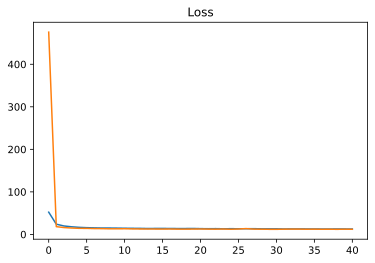

In [108]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [109]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [110]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.00%


In [111]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [112]:
blend_predict = (test_predict_nn1[:,0] + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.49%


In [113]:
blend_sub_predict = (test_predict_nn1[:,0] + test_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

ValueError: Length of values (1003) does not match length of index (1671)

# Model Bonus: проброс признака

In [114]:
# MLP
# model_mlp = Sequential()
# model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(256, activation="relu"))
# model_mlp.add(L.Dropout(0.5))

In [115]:
# FEATURE Input
# Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
# f_productiondate = L.Flatten()(emb_productiondate) 

In [116]:
#combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
#head = L.Dense(64, activation="relu")(combinedInput)
#head = L.Dense(1, activation="linear")(head)

#model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [117]:
#model.summary()

In [118]:
#optimizer = tf.keras.optimizers.Adam(0.01)
#model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [119]:
#history = model.fit([X_train, X_train.productionDate.values], y_train,
#                    batch_size=512,
#                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                    validation_data=([X_test, X_test.productionDate.values], y_test),
#                    callbacks=callbacks_list
#                   )

In [120]:
#model.load_weights('../working/best_model.hdf5')
#test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
#print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [121]:
# 